# imports and file locations

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import os

In [2]:
data_dir = "/scratch/04703/sravula/UTAFSDataNew/new_data"

# Look at the directory structure

In [3]:
file_dirs = os.listdir(data_dir)
file_dirs = [f for f in file_dirs if "case" in f]
file_dirs.sort()
print(len(file_dirs))
print(file_dirs)

62
['case00', 'case01', 'case02', 'case03', 'case04', 'case05', 'case06', 'case07', 'case08', 'case09', 'case10', 'case11', 'case12', 'case13', 'case14', 'case15', 'case16', 'case17', 'case18', 'case19', 'case20', 'case21', 'case22', 'case23', 'case24', 'case25', 'case26', 'case27', 'case28', 'case29', 'case30', 'case31', 'case32', 'case33', 'case34', 'case35', 'case36', 'case37', 'case38', 'case39', 'case40', 'case41', 'case42', 'case43', 'case44', 'case45', 'case46', 'case47', 'case48', 'case49', 'case50', 'case51', 'case52', 'case53', 'case54', 'case55', 'case56', 'case57', 'case58', 'case59', 'case60', 'case61']


In [4]:
fname = os.path.join(data_dir, file_dirs[3])
print(fname)

/scratch/04703/sravula/UTAFSDataNew/new_data/case03


In [5]:
chip_num = int(fname.split("case")[-1])
print(chip_num)

3


# Descriptions of files
- caseID.HLAS.sNp – The result of our own adaptive frequency sweep and internal vector fit
- SIEMENS_AFS_SAMPLE_POINTS.csv – The sample points chosen by our adaptive sweep
- caseID.sNp – The Touchstone ground truth file
- SIEMENS_AFS_SAMPLE_POINT_SIMULATIONS.sNp – This is just caseID.sNp sampled at the frequencies specified in SIEMENS_AFS_SAMPLE_POINTS.csv

# We want a function that will take int 0-61 and returns:
- the fully-sampled S-parameters (ground truth)
- the sample frequencies chosen by VF for the chip
- VF output for the S-params  (x_hat_VF)

## 1. "SIEMENS_AFS_SAMPLE_POINTS.csv" - Given Fs

In [6]:
given_sample_path = os.path.join(fname, 'SIEMENS_AFS_SAMPLE_POINTS.csv')
df = pd.read_csv(given_sample_path, sep=',', header=None)

In [7]:
df.head()

,0
0,0.000000e+00
1,1.000000e+04
2,8.181888e+04
3,6.694330e+05
4,5.477226e+06


In [8]:
given_samples = df[0].to_numpy().astype(np.float32).squeeze()

print(given_samples.shape)
print(given_samples)

(13,)
[0.0000000e+00 1.0000000e+04 8.1818883e+04 6.6943294e+05 5.4772255e+06
 4.4814048e+07 3.6666352e+08 3.0000000e+09 6.3750001e+09 9.7499996e+09
 1.6500000e+10 2.3250000e+10 3.0000001e+10]


## 2. "caseID.sNp" - Ground Truth S-parameters

In [9]:
children = os.listdir(fname)
children = [f for f in children if str(chip_num)+".s" in f]

if len(children) > 1:
    print("ERROR: MORE THAN ONE GT FILE")
print(children)

gt_path = os.path.join(fname, children[0])

['case03.s4p']


In [10]:
from skrf import Network, Frequency

gt_network = Network(gt_path)

print(gt_network)

4-Port Network: 'case03',  0.0-30000000000.0 Hz, 101 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]


In [11]:
print(gt_network.f)

[0.00000000e+00 1.00000000e+04 3.03040202e+08 6.06070404e+08
 9.09100606e+08 1.21213081e+09 1.51516101e+09 1.81819121e+09
 2.12122141e+09 2.42425162e+09 2.72728182e+09 3.03031202e+09
 3.33334222e+09 3.63637242e+09 3.93940263e+09 4.24243283e+09
 4.54546303e+09 4.84849323e+09 5.15152343e+09 5.45455364e+09
 5.75758384e+09 6.06061404e+09 6.36364424e+09 6.66667444e+09
 6.96970465e+09 7.27273485e+09 7.57576505e+09 7.87879525e+09
 8.18182545e+09 8.48485566e+09 8.78788586e+09 9.09091606e+09
 9.39394626e+09 9.69697646e+09 1.00000067e+10 1.03030369e+10
 1.06060671e+10 1.09090973e+10 1.12121275e+10 1.15151577e+10
 1.18181879e+10 1.21212181e+10 1.24242483e+10 1.27272785e+10
 1.30303087e+10 1.33333389e+10 1.36363691e+10 1.39393993e+10
 1.42424295e+10 1.45454597e+10 1.48484899e+10 1.51515201e+10
 1.54545503e+10 1.57575805e+10 1.60606107e+10 1.63636409e+10
 1.66666711e+10 1.69697013e+10 1.72727315e+10 1.75757617e+10
 1.78787919e+10 1.81818221e+10 1.84848523e+10 1.87878825e+10
 1.90909127e+10 1.939394

In [12]:
gt_matrix_re = gt_network.s.real.astype(np.float32)
gt_matrix_im = gt_network.s.imag.astype(np.float32)
gt_matrix = np.stack((gt_matrix_re, gt_matrix_im), axis=-1)

gt_freqs = gt_network.f.astype(np.float32).squeeze()

print(gt_matrix.shape)
print(gt_matrix.dtype)

print(gt_freqs.shape)
print(gt_freqs.dtype)

(101, 4, 4, 2)
float32
(101,)
float32


## 3. "caseID.HLAS.sNp" - VF output

In [13]:
children = os.listdir(fname)
children = [f for f in children if str(chip_num)+".HLAS.s" in f]

if len(children) > 1:
    print("ERROR: MORE THAN ONE VF FILE")
print(children)

vf_path = os.path.join(fname, children[0])

['case03.HLAS.s4p']


In [14]:
vf_network = Network(vf_path)

print(vf_network)

4-Port Network: 'case03.HLAS',  0.0-30000000000.0 Hz, 101 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]


In [15]:
print(vf_network.f)

[0.00000e+00 1.00000e+04 3.03040e+08 6.06070e+08 9.09101e+08 1.21213e+09
 1.51516e+09 1.81819e+09 2.12122e+09 2.42425e+09 2.72728e+09 3.03031e+09
 3.33334e+09 3.63637e+09 3.93940e+09 4.24243e+09 4.54546e+09 4.84849e+09
 5.15152e+09 5.45455e+09 5.75758e+09 6.06061e+09 6.36364e+09 6.66667e+09
 6.96970e+09 7.27273e+09 7.57577e+09 7.87880e+09 8.18183e+09 8.48486e+09
 8.78789e+09 9.09092e+09 9.39395e+09 9.69698e+09 1.00000e+10 1.03030e+10
 1.06061e+10 1.09091e+10 1.12121e+10 1.15152e+10 1.18182e+10 1.21212e+10
 1.24242e+10 1.27273e+10 1.30303e+10 1.33333e+10 1.36364e+10 1.39394e+10
 1.42424e+10 1.45455e+10 1.48485e+10 1.51515e+10 1.54546e+10 1.57576e+10
 1.60606e+10 1.63636e+10 1.66667e+10 1.69697e+10 1.72727e+10 1.75758e+10
 1.78788e+10 1.81818e+10 1.84849e+10 1.87879e+10 1.90909e+10 1.93939e+10
 1.96970e+10 2.00000e+10 2.03030e+10 2.06061e+10 2.09091e+10 2.12121e+10
 2.15152e+10 2.18182e+10 2.21212e+10 2.24242e+10 2.27273e+10 2.30303e+10
 2.33333e+10 2.36364e+10 2.39394e+10 2.42424e+10 2.

In [16]:
vf_matrix_re = vf_network.s.real.astype(np.float32)
vf_matrix_im = vf_network.s.imag.astype(np.float32)
vf_matrix = np.stack((vf_matrix_re, vf_matrix_im), axis=-1)

vf_freqs = vf_network.f.astype(np.float32).squeeze()

print(vf_matrix.shape)
print(vf_matrix.dtype)

print(vf_freqs.shape)
print(vf_freqs.dtype)

(101, 4, 4, 2)
float32
(101,)
float32


## 4. "SIEMENS_AFS_SAMPLE_POINT_SIMULATIONS.sNp" - GT sampled at the given Fs

In [17]:
children = os.listdir(fname)
children = [f for f in children if "SIEMENS_AFS_SAMPLE_POINT_SIMULATIONS.s" in f]

if len(children) > 1:
    print("ERROR: MORE THAN ONE SAMPLED GT FILE")
print(children)

y_path = os.path.join(fname, children[0])

['SIEMENS_AFS_SAMPLE_POINT_SIMULATIONS.s4p']


In [18]:
y_network = Network(y_path)

print(y_network)

4-Port Network: 'SIEMENS_AFS_SAMPLE_POINT_SIMULATIONS',  0.0-30000000000.0 Hz, 13 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]


In [19]:
print(y_network.f)

[0.00000000e+00 1.00000000e+04 8.18188823e+04 6.69432950e+05
 5.47722558e+06 4.48140475e+07 3.66663528e+08 3.00000000e+09
 6.37500000e+09 9.75000000e+09 1.65000000e+10 2.32500000e+10
 3.00000000e+10]


In [20]:
y_matrix_re = y_network.s.real.astype(np.float32)
y_matrix_im = y_network.s.imag.astype(np.float32)
y_matrix = np.stack((y_matrix_re, y_matrix_im), axis=-1)

y_freqs = y_network.f.astype(np.float32).squeeze()

print(y_matrix.shape)
print(y_matrix.dtype)

print(y_freqs.shape)
print(y_freqs.dtype)

(13, 4, 4, 2)
float32
(13,)
float32


## Now compare the plots

In [21]:
diff_0 = y_network.s[0] - gt_network.s[0]
diff_1 = y_network.s[1] - gt_network.s[1]
diff_2 = y_network.s[2] - gt_network.s[2]

print(diff_0)
print(diff_1)
print(diff_2)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[-7.37871002e-03-0.01886208j  8.70045948e-03+0.0701633j
  -8.50099153e-05-0.00043066j  6.92164850e-05+0.00012099j]
 [ 8.70045948e-03+0.0701633j  -7.37961983e-03-0.01886648j
   6.92164835e-05+0.00012099j -8.41000030e-05-0.00042627j]
 [-8.50099153e-05-0.00043066j  6.92164835e-05+0.00012099j
  -7.37872657e-03-0.0188621j   8.70046148e-03+0.07016331j]
 [ 6.92164850e-05+0.00012099j -8.41000030e-05-0.00042627j
   8.70046148e-03+0.07016331j -7.37963672e-03-0.0188665j ]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


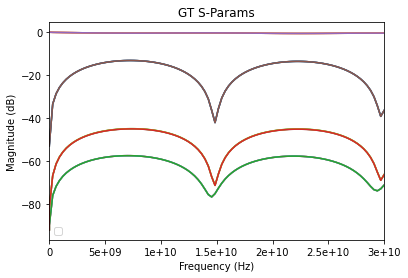

In [22]:
plt.title('GT S-Params')
gt_network.plot_s_db(label="")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


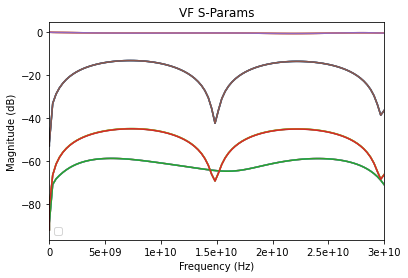

In [23]:
plt.title('VF S-Params')
vf_network.plot_s_db(label="")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


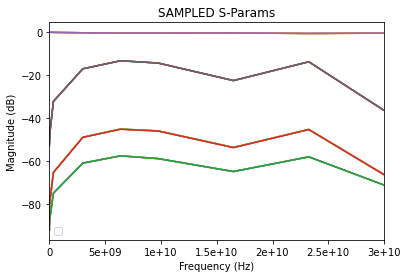

In [24]:
plt.title('SAMPLED S-Params')
y_network.plot_s_db(label="")

## Try to interpolate the network and see what happens

In [25]:
print(gt_network)

4-Port Network: 'case03',  0.0-30000000000.0 Hz, 101 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]


In [26]:
import copy

old_net = copy.deepcopy(gt_network)

In [27]:
gt_network.resample(128)

In [28]:
new_net = copy.deepcopy(gt_network)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


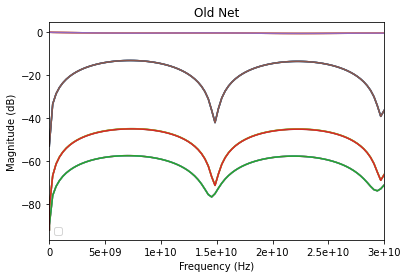

In [29]:
plt.title('Old Net')
old_net.plot_s_db(label="")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


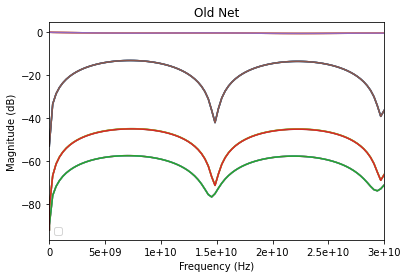

In [30]:
plt.title('Old Net')
old_net.plot_s_db(label="")

In [31]:
overlap_inds = []

for i, f_old in enumerate(old_net.f):
    for j, f_new in enumerate(new_net.f):
        if f_old == f_new:
            overlap_inds.append((f_old, f_new))

In [32]:
print(len(overlap_inds))

2


In [33]:
print(old_net.f)

[0.00000000e+00 1.00000000e+04 3.03040202e+08 6.06070404e+08
 9.09100606e+08 1.21213081e+09 1.51516101e+09 1.81819121e+09
 2.12122141e+09 2.42425162e+09 2.72728182e+09 3.03031202e+09
 3.33334222e+09 3.63637242e+09 3.93940263e+09 4.24243283e+09
 4.54546303e+09 4.84849323e+09 5.15152343e+09 5.45455364e+09
 5.75758384e+09 6.06061404e+09 6.36364424e+09 6.66667444e+09
 6.96970465e+09 7.27273485e+09 7.57576505e+09 7.87879525e+09
 8.18182545e+09 8.48485566e+09 8.78788586e+09 9.09091606e+09
 9.39394626e+09 9.69697646e+09 1.00000067e+10 1.03030369e+10
 1.06060671e+10 1.09090973e+10 1.12121275e+10 1.15151577e+10
 1.18181879e+10 1.21212181e+10 1.24242483e+10 1.27272785e+10
 1.30303087e+10 1.33333389e+10 1.36363691e+10 1.39393993e+10
 1.42424295e+10 1.45454597e+10 1.48484899e+10 1.51515201e+10
 1.54545503e+10 1.57575805e+10 1.60606107e+10 1.63636409e+10
 1.66666711e+10 1.69697013e+10 1.72727315e+10 1.75757617e+10
 1.78787919e+10 1.81818221e+10 1.84848523e+10 1.87878825e+10
 1.90909127e+10 1.939394

In [34]:
print(new_net.f)

[0.00000000e+00 2.36220472e+08 4.72440945e+08 7.08661417e+08
 9.44881890e+08 1.18110236e+09 1.41732283e+09 1.65354331e+09
 1.88976378e+09 2.12598425e+09 2.36220472e+09 2.59842520e+09
 2.83464567e+09 3.07086614e+09 3.30708661e+09 3.54330709e+09
 3.77952756e+09 4.01574803e+09 4.25196850e+09 4.48818898e+09
 4.72440945e+09 4.96062992e+09 5.19685039e+09 5.43307087e+09
 5.66929134e+09 5.90551181e+09 6.14173228e+09 6.37795276e+09
 6.61417323e+09 6.85039370e+09 7.08661417e+09 7.32283465e+09
 7.55905512e+09 7.79527559e+09 8.03149606e+09 8.26771654e+09
 8.50393701e+09 8.74015748e+09 8.97637795e+09 9.21259843e+09
 9.44881890e+09 9.68503937e+09 9.92125984e+09 1.01574803e+10
 1.03937008e+10 1.06299213e+10 1.08661417e+10 1.11023622e+10
 1.13385827e+10 1.15748031e+10 1.18110236e+10 1.20472441e+10
 1.22834646e+10 1.25196850e+10 1.27559055e+10 1.29921260e+10
 1.32283465e+10 1.34645669e+10 1.37007874e+10 1.39370079e+10
 1.41732283e+10 1.44094488e+10 1.46456693e+10 1.48818898e+10
 1.51181102e+10 1.535433

In [35]:
gt_network.resample(old_net.f / 1e9)

In [36]:
gt_network

4-Port Network: 'case03',  0.0-30.0 GHz, 101 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]

In [37]:
diff = gt_network.s - old_net.s
sq_diff = np.square(np.abs(diff))
mse = np.mean(sq_diff)
print(mse)

9.018029694098703e-08


In [38]:
print(len(gt_network.f))

101
